In [28]:
import pandas as pd
import numpy as np

# prepare the dataset

In [29]:
df = pd.read_csv('data.csv')
df.head()

,observation,id,choice_set,rate,brand,price,sound_quality,library_size,with_lyrics,downloadable
0,1,1,1,1,joox,19,1411,10,0,0
1,2,1,2,8,joox,24,256,30,1,0
2,3,1,3,1,joox,29,320,50,1,1
3,4,1,4,1,kkbox,19,256,50,0,1
4,5,1,5,8,kkbox,24,320,30,1,0


In [30]:
# convert 'brand' to dummy variables
df[['is_joox', 'is_kkbox', 'is_spotify', 'is_moov']] = pd.get_dummies(df.brand)
df = df.drop('brand', axis=1)
df.head()

,observation,id,choice_set,rate,price,sound_quality,library_size,with_lyrics,downloadable,is_joox,is_kkbox,is_spotify,is_moov
0,1,1,1,1,19,1411,10,0,0,1,0,0,0
1,2,1,2,8,24,256,30,1,0,1,0,0,0
2,3,1,3,1,29,320,50,1,1,1,0,0,0
3,4,1,4,1,19,256,50,0,1,0,1,0,0
4,5,1,5,8,24,320,30,1,0,0,1,0,0


In [31]:
# convert 'sound_quality' into dummy variables
df[['sq_256', 'sq_320', 'sq_1411']] = pd.get_dummies(df.sound_quality)
df = df.drop('sound_quality', axis=1)
df.head()

,observation,id,choice_set,rate,price,library_size,with_lyrics,downloadable,is_joox,is_kkbox,is_spotify,is_moov,sq_256,sq_320,sq_1411
0,1,1,1,1,19,10,0,0,1,0,0,0,0,0,1
1,2,1,2,8,24,30,1,0,1,0,0,0,1,0,0
2,3,1,3,1,29,50,1,1,1,0,0,0,0,1,0
3,4,1,4,1,19,50,0,1,0,1,0,0,1,0,0
4,5,1,5,8,24,30,1,0,0,1,0,0,0,1,0


In [33]:
# splitting X and y
y = df['rate']
X = df[['price', 'library_size', 'with_lyrics', 'downloadable', 
        'is_joox', 'is_kkbox', 'is_spotify', 'is_moov', 
        'sq_256', 'sq_320', 'sq_1411']]

# conjoint analysis

In [34]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [36]:
res = sm.OLS(y, X, family=sm.families.Binomial()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.668
Date:                Mon, 27 Jul 2020   Prob (F-statistic):           3.41e-09
Time:                        16:27:09   Log-Likelihood:                -1641.7
No. Observations:                 720   AIC:                             3303.
Df Residuals:                     710   BIC:                             3349.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
price           -0.1807      0.124     -1.456      0.146      -0.424       0.063
library_size     0.0300      0.015      1.962      0.050   -2.24e-05       0.060
with_lyrics      1.4535      0.942      1.544      0.123      -0.395       3.302
downloadable     1.2171      0.511      2.383      0.017       0.214       2.220
is_joox          2.6189      0.964      2.718      0.007       0.727       4.511
is_kkbox         2.8077      0.826      3.400      0.001       1.186       4.429
is_spotify       2.3114      0.794      2.912      0.004       0.753       3.870
is_moov          3.6364      1.112      3.270      0.001       1.453       5.820
sq_256           3.5436      1.114      3.182      0.002       1.357       5.730
sq_320           3.5490      1.207      2.941      0.003       1.180       5.918
sq_1411          4.2818      1.379      3.105      0.002       1.575       6.989
==============================================================================
Omnibus:                       60.696   Durbin-Watson:                   1.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.211
Skew:                          -0.066   Prob(JB):                     4.09e-05
Kurtosis:                       2.190   Cond. No.                     1.68e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.47e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
df_res = pd.DataFrame({
    'param_name': res.params.keys()
    , 'param_w': res.params.values
    , 'pval': res.pvalues
})
# adding field for absolute of parameters
df_res['abs_param_w'] = np.abs(df_res['param_w'])
# marking field is significant under 95% confidence interval
df_res['is_sig_95'] = (df_res['pval'] < 0.05)
# constructing color naming for each param
df_res['c'] = ['blue' if x else 'red' for x in df_res['is_sig_95']]

# make it sorted by abs of parameter value
df_res = df_res.sort_values(by='abs_param_w', ascending=True)

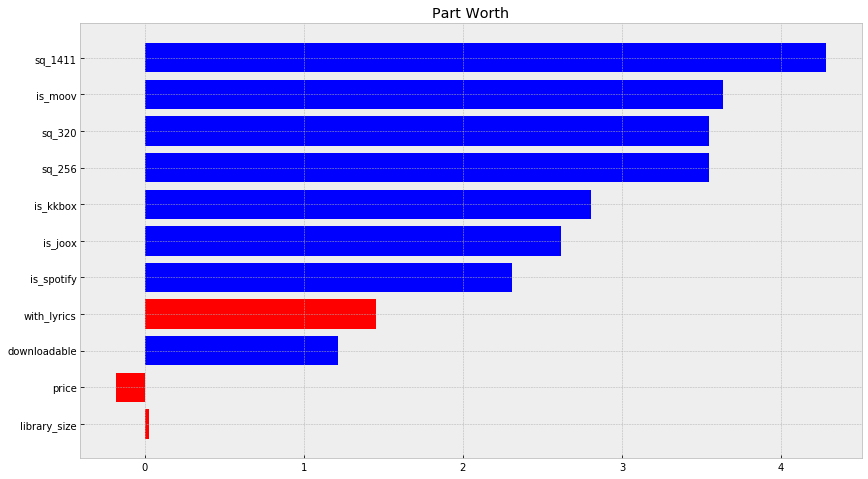

In [38]:
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Part Worth')
pwu = df_res['param_w']
xbar = np.arange(len(pwu))
plt.barh(xbar, pwu, color=df_res['c'])
plt.yticks(xbar, labels=df_res['param_name'])
plt.show()

In [39]:
# need to assemble per attribute for every level of that attribute in dicionary
range_per_feature = dict()
for key, coeff in res.params.items():
    sk =  key.split('_')
    feature = sk[0]
    if len(sk) == 1:
        feature = key
    if feature not in range_per_feature:
        range_per_feature[feature] = list()
        
    range_per_feature[feature].append(coeff)

In [40]:
# importance per feature is range of coef in a feature
# while range is simply max(x) - min(x)
importance_per_feature = {
    k: max(v) - min(v) for k, v in range_per_feature.items()
}

# compute relative importance per feature
# or normalized feature importance by dividing 
# sum of importance for all features
total_feature_importance = sum(importance_per_feature.values())
relative_importance_per_feature = {
    k: 100 * round(v/total_feature_importance, 3) for k, v in importance_per_feature.items()
}

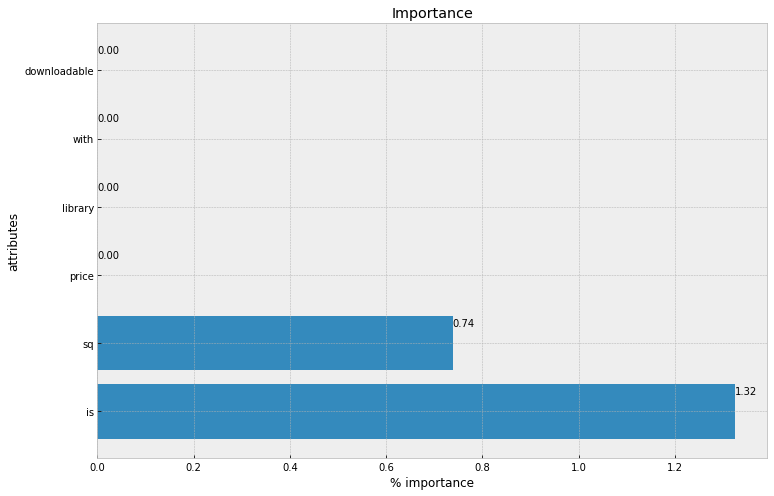

In [41]:
alt_data = pd.DataFrame(
    list(importance_per_feature.items()), 
    columns=['attr', 'importance']
).sort_values(by='importance', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Importance')
plt.barh(xbar, alt_data['importance'])
for i, v in enumerate(alt_data['importance']):
    ax.text(v , i + .25, '{:.2f}'.format(v))
plt.ylabel('attributes')
plt.xlabel('% importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()

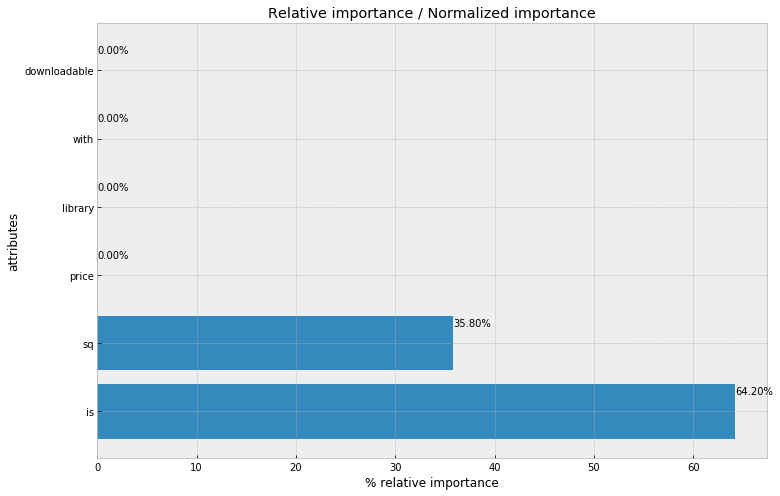

In [42]:
alt_data = pd.DataFrame(
    list(relative_importance_per_feature.items()), 
    columns=['attr', 'relative_importance (pct)']
).sort_values(by='relative_importance (pct)', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Relative importance / Normalized importance')
plt.barh(xbar, alt_data['relative_importance (pct)'])
for i, v in enumerate(alt_data['relative_importance (pct)']):
    ax.text(v , i + .25, '{:.2f}%'.format(v))
plt.ylabel('attributes')
plt.xlabel('% relative importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()